In [1]:
path_data = '../../data/'

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# The Bootstrap
A data scientist is using the data in a random sample to estimate an unknown parameter. She uses the sample to calculate the value of a statistic that she will use as her estimate. 

Once she has calculated the observed value of her statistic, she could just present it as her estimate and go on her merry way. But she's a data scientist. She knows that her random sample is just one of numerous possible random samples, and thus her estimate is just one of numerous plausible estimates. 

By how much could those estimates vary? To answer this, it appears as though she needs to draw another sample from the population, and compute a new estimate based on the new sample. But she doesn't have the resources to go back to the population and draw another sample.

It looks as though the data scientist is stuck.

Fortunately, a brilliant idea called *the bootstrap* can help her out. Since it is not feasible to generate new samples from the population, the bootstrap generates new random samples by a method called *resampling*: the new samples are drawn at random *from the original sample*.

In this section, we will see how and why the bootstrap works. In the rest of the chapter, we will use the bootstrap for inference.



## Employee Compensation in the City of San Francisco
[SF OpenData](https://data.sfgov.org) is a website where the City and County of San Francisco make some of their data publicly available. One of the data sets contains compensation data for employees of the City. These include medical professionals at City-run hospitals, police officers, fire fighters, transportation workers, elected officials, and all other employees of the City. 

Compensation data for the calendar year 2015 are in the table `sf2015`.

In [2]:
sf2015 = pd.read_csv(path_data + 'san_francisco_2015.csv')

In [3]:
sf2015.head(10)

Year Type  Year  Organization Group Code  \
0  Calendar  2015                        2   
1  Calendar  2015                        2   
2  Calendar  2015                        4   
3  Calendar  2015                        4   
4  Calendar  2015                        2   
5  Calendar  2015                        1   
6  Calendar  2015                        4   
7  Calendar  2015                        2   
8  Calendar  2015                        6   
9  Calendar  2015                        3   

                         Organization Group Department Code  \
0   Public Works, Transportation & Commerce             WTR   
1   Public Works, Transportation & Commerce             DPW   
2                          Community Health             DPH   
3                          Community Health             DPH   
4   Public Works, Transportation & Commerce             MTA   
5                         Public Protection             POL   
6                          Community Health             DPH   
7   Public Works, Transportation & Commerce             MTA   
8          General Administration & Finance             CAT   
9  Human Welfare & Neighborhood Development             DSS   

                               Department  Union Code  \
0                    PUC Water Department        21.0   
1  General Services Agency - Public Works        12.0   
2                           Public Health       790.0   
3                           Public Health       351.0   
4         Municipal Transportation Agency       790.0   
5                                  Police       911.0   
6                           Public Health       791.0   
7         Municipal Transportation Agency       253.0   
8                           City Attorney       311.0   
9                          Human Services       535.0   

                                               Union Job Family Code  \
0    Prof & Tech Engineers - Miscellaneous, Local 21            2400   
1   Carpet, Linoleum and Soft Tile Workers, Local 12            7300   
2                   SEIU - Miscellaneous, Local 1021            1600   
3    Municipal Executive Association - Miscellaneous            0900   
4                   SEIU - Miscellaneous, Local 1021            8200   
5                       Police Officers' Association            Q000   
6       SEIU - Staff and Per Diem Nurses, Local 1021            2300   
7  Transport Workers - Transit Operators, Local 2...            9100   
8                   Municipal Attorneys' Association            8100   
9                  SEIU - Human Services, Local 1021            9700   

                      Job Family  ... Employee Identifier   Salaries  \
0      Lab, Pharmacy & Med Techs  ...               21538   82146.04   
1               Journeyman Trade  ...                5459   32165.75   
2  Payroll, Billing & Accounting  ...               41541   71311.00   
3                     Management  ...               26718   28430.25   
4      Protection & Apprehension  ...               45810    7948.75   
5                Police Services  ...               32906    2235.00   
6                        Nursing  ...                7506  187247.00   
7                 Street Transit  ...               36773   66988.54   
8                  Legal & Court  ...               12963  135189.60   
9          Community Development  ...               35179   70474.77   

   Overtime  Other Salaries  Total Salary  Retirement  Health/Dental  \
0      0.00            0.00      82146.04    16942.21       12340.88   
1    973.19          848.96      33987.90        0.00        4587.51   
2   5757.98            0.00      77068.98    14697.59       12424.50   
3      0.00          763.07      29193.32        0.00        4223.14   
4      0.00            0.00       7948.75        0.00        2873.17   
5      0.00            0.00       2235.00      490.36         286.72   
6      0.00        11704.06     198951.06    37683.66       12424.50   
7   3512.88

There is one row for each of 42,979 employees. There are numerous columns containing information about City departmental affiliation and details of the different parts of the employee's compensation package. Here is the row correspoding to the late Edward Lee, the Mayor at that time.

In [4]:
sf2015[sf2015['Job'] == 'Mayor']

Year Type  Year  Organization Group Code  \
3335  Calendar  2015                        6   

                    Organization Group Department Code Department  Union Code  \
3335  General Administration & Finance             MYR      Mayor       556.0   

                  Union Job Family Code                     Job Family  ...  \
3335  Elected Officials            1100  Administrative & Mgmt (Unrep)  ...   

     Employee Identifier   Salaries  Overtime  Other Salaries  Total Salary  \
3335               22433  288963.55       0.0             0.0     288963.55   

      Retirement  Health/Dental  Other Benefits  Total Benefits  \
3335    58117.03        12424.5        20292.95        90834.48   

      Total Compensation  
3335           379798.03  

[1 rows x 22 columns]

We are going to study the final column, `Total Compensation`. That's the employee's salary plus the City's contribution towards his/her retirement and benefit plans.

Financial packages in a calendar year can sometimes be hard to understand as they depend on the date of hire, whether the employee is changing jobs within the City, and so on. For example, the lowest values in the `Total Compensation` column look a little strange.

In [5]:
sf2015.sort_values(by=['Total Compensation'])

Year Type  Year  Organization Group Code  \
27308  Calendar  2015                        1   
15746  Calendar  2015                        4   
24576  Calendar  2015                        1   
42982  Calendar  2015                        6   
23310  Calendar  2015                        6   
...         ...   ...                      ...   
5171   Calendar  2015                        4   
17805  Calendar  2015                        2   
499    Calendar  2015                        6   
13194  Calendar  2015                        6   
19177  Calendar  2015                        6   

                            Organization Group Department Code  \
27308                        Public Protection             FIR   
15746                         Community Health             DPH   
24576                        Public Protection             JUV   
42982         General Administration & Finance             CPC   
23310         General Administration & Finance             CPC   
...                                        ...             ...   
5171                          Community Health             DPH   
17805  Public Works, Transportation & Commerce             AIR   
499           General Administration & Finance             ADM   
13194         General Administration & Finance             ADM   
19177         General Administration & Finance             RET   

                                 Department  Union Code  \
27308                       Fire Department       798.0   
15746                         Public Health       790.0   
24576                    Juvenile Probation       790.0   
42982                         City Planning        21.0   
23310                         City Planning        21.0   
...                                     ...         ...   
5171                          Public Health       351.0   
17805                    Airport Commission       351.0   
499    General Services Agency - City Admin       164.0   
13194  General Services Agency - City Admin       164.0   
19177                     Retirement System       351.0   

                                                 Union Job Family Code  \
27308          Firefighters - Miscellaneous, Local 798            H000   
15746                 SEIU - Miscellaneous, Local 1021            9900   
24576                 SEIU - Miscellaneous, Local 1021            8300   
42982  Prof & Tech Engineers - Miscellaneous, Local 21            1000   
23310  Prof & Tech Engineers - Miscellaneous, Local 21            5200   
...                                                ...             ...   
5171   Municipal Executive Association - Miscellaneous            0900   
17805  Municipal Executive Association - Miscellaneous            0900   
499            Physicians and Dentists - Miscellaneous            2500   
13194          Physicians and Dentists - Miscellaneous            2500   
19177  Municipal Executive Association - Miscellaneous            1100   

                          Job Family  ... Employee Identifier   Salaries  \
27308                  Fire Services  ...               43833       0.00   
15746            Public Service Aide  ...               27871    -292.40   
24576         Correction & Detention  ...               10517       0.00   
42982            Information Systems  ...               18961       0.00   
23310       Professional Engineering  ...               19387       0.00   
...                              ...  ...                 ...        ...   
5171                      Management  ...                1523  256098.01   
17805                     Management  ...               17356  326764.01   
499          Med Therapy & Auxiliary  ...               13746  279311.03   
13194        Med Therapy & Auxiliary  ...                1016  279311.10   
19177  Administrative & Mgmt (Unrep)  ...               46881  507831.60   

       Overtime  Other Salaries  Total Salary  Retirement  Health/Dental  \
27308      0.00          

For clarity of comparison, we will focus our attention on those who had at least the equivalent of a half-time job for the whole year. At a minimum wage of about \$10 per hour, and 20 hours per week for 52 weeks, that's a salary of about \$10,000.

In [6]:
sf2015 = sf2015[sf2015['Salaries'] > 10000]

In [7]:
len(sf2015)

36569

### Population and Parameter
Let this table of just over 36,500 rows be our population. Here is a histogram of the total compensations.

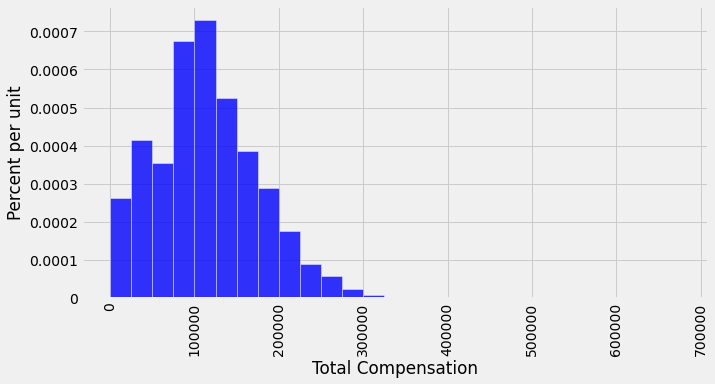

In [8]:
sf_bins = np.arange(0, 700000, 25000)

unit = ''

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(sf2015['Total Compensation'], bins = sf_bins, density=True, color='blue', alpha=0.8, ec='white')

#ax.scatter(observed_distance, 0, color='red', s=40, zorder=10).set_clip_on(False)

y_vals = ax.get_yticks()

y_label = 'Percent per ' + (unit if unit else 'unit')

x_label = 'Total Compensation'

ax.set_yticklabels(['{:g}'.format(x * 100) for x in y_vals])

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.xticks(rotation=90)

plt.title('');

plt.show()

While most of the values are below \\$300,000,  a few are quite a bit higher. For example, the total compensation of the Chief Investment Officer was almost \\$650,000. That is why the horizontal axis stretches to \\$700,000.

In [9]:
sf2015.sort_values(by=['Total Compensation'], ascending=False).head(2)

Year Type  Year  Organization Group Code  \
19177  Calendar  2015                        6   
13194  Calendar  2015                        6   

                     Organization Group Department Code  \
19177  General Administration & Finance             RET   
13194  General Administration & Finance             ADM   

                                 Department  Union Code  \
19177                     Retirement System       351.0   
13194  General Services Agency - City Admin       164.0   

                                                 Union Job Family Code  \
19177  Municipal Executive Association - Miscellaneous            1100   
13194          Physicians and Dentists - Miscellaneous            2500   

                          Job Family  ... Employee Identifier  Salaries  \
19177  Administrative & Mgmt (Unrep)  ...               46881  507831.6   
13194        Med Therapy & Auxiliary  ...                1016  279311.1   

       Overtime  Other Salaries  Total Salary  Retirement  Health/Dental  \
19177      0.00            0.00     507831.60   105052.98        12424.5   
13194   3829.36       114433.58     397574.04    56211.64        12424.5   

       Other Benefits  Total Benefits  Total Compensation  
19177        23566.16       141043.64           648875.24  
13194        14299.10        82935.24           480509.28  

[2 rows x 22 columns]

Now let the parameter be the median of the total compensations.

Since we have the luxury of having all of the data from the population, we can simply calculate the parameter:

In [10]:
pop_median = np.percentile(sf2015['Total Compensation'], 50)
pop_median

110305.79

The median total compensation of all employees was just over \$110,300. 

From a practical perspective, there is no reason for us to draw a sample to estimate this parameter since we simply know its value. But in this section we are going to pretend we don't know the value, and see how well we can estimate it based on a random sample. 

In later sections, we will come down to earth and work in situations where the parameter is unknown. For now, we are all-knowing.

### A Random Sample and an Estimate
Let us draw a sample of 500 employees at random without replacement, and let the median total compensation of the sampled employees serve as our estimate of the parameter.

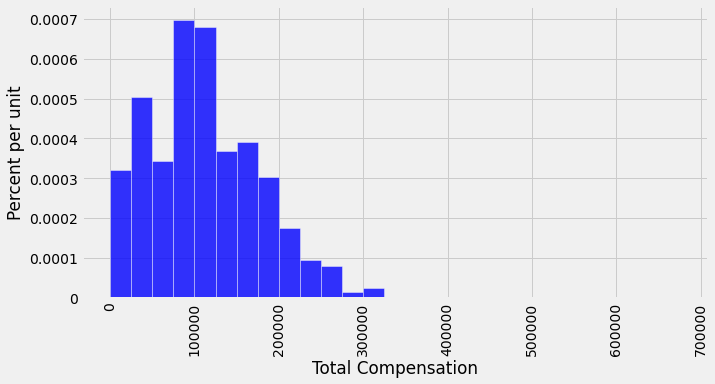

In [11]:
our_sample = sf2015.sample(500, replace=False)

unit = ''

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(our_sample['Total Compensation'], bins = sf_bins, density=True, color='blue', alpha=0.8, ec='white')

y_vals = ax.get_yticks()

y_label = 'Percent per ' + (unit if unit else 'unit')

x_label = 'Total Compensation'

ax.set_yticklabels(['{:g}'.format(x * 100) for x in y_vals])

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.xticks(rotation=90)

plt.title('');

plt.show()

In [12]:
est_median = np.percentile(our_sample['Total Compensation'], 50)
est_median

106524.32

The sample size is large. By the law of averages, the distribution of the sample resembles that of the population, and consequently the sample median is not very far from the population median (though of course it is not exactly the same).

So now we have one estimate of the parameter. But had the sample come out differently, the estimate would have had a different value. We would like to be able to quantify the amount by which the estimate could vary across samples. That measure of variability will help us measure how accurately we can estimate the parameter.

To see how different the estimate would be if the sample had come out differently, we could just draw another sample from the population, but that would be cheating. We are trying to mimic real life, in which we won't have all the population data at hand.

Somehow, we have to get another random sample without sampling from the population.

### The Bootstrap: Resampling from the Sample
What we do have is a large random sample from the population. As we know, a large random sample is likely to resemble the population from which it is drawn. This observation allows data scientists to *lift themselves up by their own bootstraps*: the sampling procedure can be replicated by *sampling from the sample*. 

Here are the steps of *the bootstrap method* for generating another random sample that resembles the population:

- **Treat the original sample as if it were the population.**
- **Draw from the sample**, at random **with** replacement, **the same number of times as the original sample size**. 

It is important to resample the same number of times as the original sample size. The reason is that the variability of an estimate depends on the size of the sample. Since our original sample consisted of 500 employees, our sample median was based on 500 values. To see how different the sample could have been, we have to compare it to the median of other samples of size 500.

If we drew 500 times at random *without* replacement from our sample of size 500, we would just get the same sample back. By drawing *with* replacement, we create the possibility for the new samples to be different from the original, because some employees might be drawn more than once and others not at all.

Why is this a good idea? By the law of averages, the distribution of the original sample is likely to resemble the population, and the distributions of all the "resamples" are likely to resemble the original sample. So the distributions of all the resamples are likely to resemble the population as well. 

![Bootstrap](../../images/bootstrap_pic.png)

### A Resampled Median
Recall that when the `sample` method is used without specifying a sample size, by default the sample size equals the number of rows of the table from which the sample is drawn. That's perfect for the bootstrap! Here is one new sample drawn from the original sample, and the corresponding sample median.

In [13]:
resample_1 = our_sample.sample(len(our_sample), replace=True)
resample_1

Year Type  Year  Organization Group Code  \
8264   Calendar  2015                        4   
4685   Calendar  2015                        4   
12319  Calendar  2015                        2   
23490  Calendar  2015                        3   
15708  Calendar  2015                        4   
...         ...   ...                      ...   
23644  Calendar  2015                        5   
8710   Calendar  2015                        4   
25486  Calendar  2015                        1   
11368  Calendar  2015                        1   
25489  Calendar  2015                        4   

                             Organization Group Department Code  \
8264                           Community Health             DPH   
4685                           Community Health             DPH   
12319   Public Works, Transportation & Commerce             DPW   
23490  Human Welfare & Neighborhood Development             DSS   
15708                          Community Health             DPH   
...                                         ...             ...   
23644                      Culture & Recreation             FAM   
8710                           Community Health             DPH   
25486                         Public Protection             POL   
11368                         Public Protection             CRT   
25489                          Community Health             DPH   

                                   Department  Union Code  \
8264                            Public Health       250.0   
4685                            Public Health       250.0   
12319  General Services Agency - Public Works        21.0   
23490                          Human Services        21.0   
15708                           Public Health       790.0   
...                                       ...         ...   
23644                        Fine Arts Museum       351.0   
8710                            Public Health       791.0   
25486                                  Police       911.0   
11368                          Superior Court       195.0   
25489                           Public Health       856.0   

                                                 Union Job Family Code  \
8264                 SEIU - Health Workers, Local 1021            2700   
4685                 SEIU - Health Workers, Local 1021            2300   
12319  Prof & Tech Engineers - Miscellaneous, Local 21            5200   
23490  Prof & Tech Engineers - Miscellaneous, Local 21            1200   
15708                 SEIU - Miscellaneous, Local 1021            9900   
...                                                ...             ...   
23644  Municipal Executive Association - Miscellaneous            0900   
8710      SEIU - Staff and Per Diem Nurses, Local 1021            2300   
25486                     Police Officers' Association            Q000   
11368                Court Unrepresented Professionals            SCRT   
25489             Teamsters - Miscellaneous, Local 856            2400   

                      Job Family  ... Employee Identifier   Salaries  \
8264      Housekeeping & Laundry  ...                2712   56531.01   
4685                     Nursing  ...               35035   17258.19   
12319   Professional Engineering  ...                4931  135421.01   
23490                  Personnel  ...               43280   92085.00   
15708        Public Service Aide  ...               35494   37494.70   
...                          ...  ...                 ...        ...   
23644                 Management  ...               35997  118427.00   
8710                     Nursing  ...                5225   17916.00   
25486            Police Services  ...               32237  140578.74   
11368          SF Superior Court  ...               43867   68656.96   
25489  Lab, Pharmacy & Med Techs  ...               27976  107416.03   

       Overtime  Other Salaries  Total Salary  Retirement  Health/Dental  \
8264     621.29         2350.53      

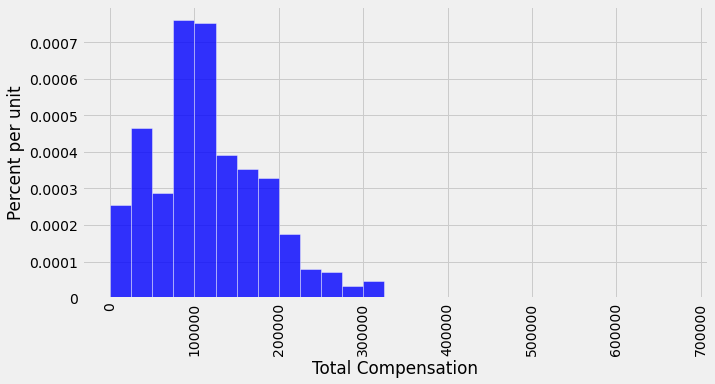

In [14]:
unit = ''

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(resample_1['Total Compensation'], bins = sf_bins, density=True, color='blue', alpha=0.8, ec='white')

y_vals = ax.get_yticks()

y_label = 'Percent per ' + (unit if unit else 'unit')

x_label = 'Total Compensation'

ax.set_yticklabels(['{:g}'.format(x * 100) for x in y_vals])

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.xticks(rotation=90)

plt.title('');

plt.show()

In [15]:
resampled_median_1 = np.percentile(resample_1['Total Compensation'], 50, interpolation='nearest')
resampled_median_1

111355.89

By resampling, we have another estimate of the population median. By resampling again and again, we will get many such estimates, and hence an empirical distribution of the estimates.

In [16]:
resample_2 = our_sample.sample(len(our_sample), replace=True)
resampled_median_2 = np.percentile(resample_2['Total Compensation'], 50, interpolation='nearest')
resampled_median_2

107778.0

### Bootstrap Empirical Distribution of the Sample Median
Let us define a function `bootstrap_median` that takes our original sample, the label of the column containing the variable, and the number of bootstrap samples we want to take, and returns an array of the corresponding resampled medians. 

Each time we resample and find the median, we *replicate* the bootstrap process. So the number of bootstrap samples will be called the number of replications.

In [17]:
def bootstrap_median(original_sample, label, replications):
    """Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    just_one_column = original_sample[label]
    medians = np.array([])
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample(len(just_one_column), replace=True)
        resampled_median = np.percentile(bootstrap_sample, 50)
        medians = np.append(medians, resampled_median)
        
    return medians

We now replicate the bootstrap process 5,000 times. The array `bstrap_medians` contains the medians of all 5,000 bootstrap samples. Notice that the code takes longer to run than our previous code. It has a lot of resampling to do!

In [18]:
bstrap_medians = bootstrap_median(our_sample, 'Total Compensation', 5000)

Here is the histogram of the 5000 medians. The red dot is the population parameter: it is the median of the entire population, which we happen to know but did not use in the bootstrap process.

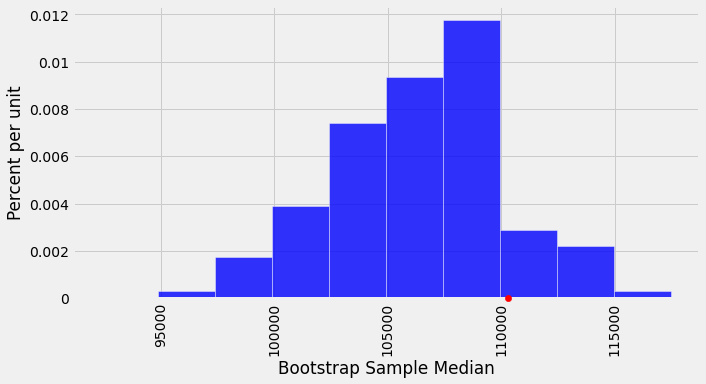

In [19]:
resampled_medians = pd.DataFrame({'Bootstrap Sample Median':bstrap_medians})

unit = ''

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(resampled_medians, density=True, color='blue', alpha=0.8, ec='white')

ax.scatter(pop_median, 0, color='red', s=40, zorder=10).set_clip_on(False)

y_vals = ax.get_yticks()

y_label = 'Percent per ' + (unit if unit else 'unit')

x_label = 'Bootstrap Sample Median'

ax.set_yticklabels(['{:g}'.format(x * 100) for x in y_vals])

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.xticks(rotation=90)

plt.title('');

plt.show()

It is important to remember that the red dot is fixed: it is \$110,305.79, the population median. The empirical histogram is the result of random draws, and will be situated randomly relative to the red dot. 

Remember also that the point of all these computations is to estimate the population median, which is the red dot. Our estimates are all the randomly generated sampled medians whose histogram you see above. We want those estimates to contain the parameter – it they don't, then they are off.

### Do the Estimates Capture the Parameter?
How often does the empirical histogram of the resampled medians sit firmly over the red dot, and not just brush the dot with its tails? To answer this, we must define "sit firmly". Let's take that to mean "the middle 95% of the resampled medians contains the red dot". 

Here are the two ends of the "middle 95%" interval of resampled medians:

In [20]:
left = np.percentile(bstrap_medians, 2.5, interpolation='nearest')
left

98658.98000000001

In [21]:
right = np.percentile(bstrap_medians, 97.5, interpolation='nearest')
right

114416.98999999999

The population median of \$110,305 is between these two numbers. The interval and the population median are shown on the histogram below.

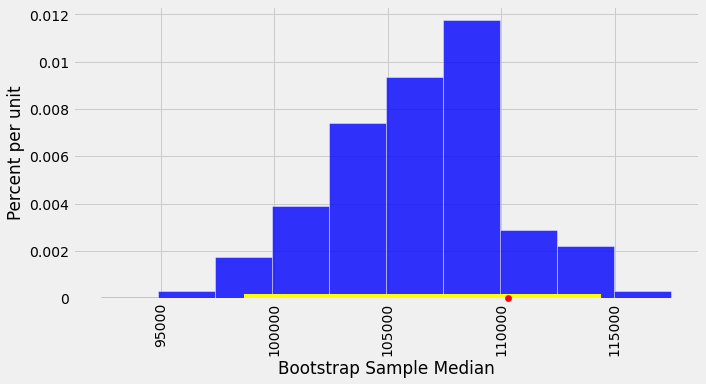

In [22]:
resampled_medians = pd.DataFrame({'Bootstrap Sample Median':bstrap_medians})

unit = ''

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(resampled_medians, density=True, color='blue', alpha=0.8, ec='white', zorder=5)

ax.plot(np.array([left, right]), np.array([0,0]), color='yellow', lw=8, zorder=10)

ax.scatter(pop_median, 0, color='red', s=40, zorder=15).set_clip_on(False)

y_vals = ax.get_yticks()

y_label = 'Percent per ' + (unit if unit else 'unit')

x_label = 'Bootstrap Sample Median'

ax.set_yticklabels(['{:g}'.format(x * 100) for x in y_vals])

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.xticks(rotation=90)

plt.title('');

plt.show()

The "middle 95%" interval of estimates captured the parameter in our example. But was that a fluke? 

To see how frequently the interval contains the parameter, we have to run the entire process over and over again. Specifically, we will repeat the following process 100 times:

- Draw an original sample of size 500 from the population.
- Carry out 5,000 replications of the bootstrap process and generate the "middle 95%" interval of resampled medians.

We will end up with 100 intervals, and count how many of them contain the population median.

**Spoiler alert:** The statistical theory of the bootstrap says that the number should be around 95. It may be in the low 90s or high 90s, but not much farther off 95 than that.

In [23]:
total_comps = sf2015[['Total Compensation']]
total_comps

Total Compensation
0               117766.86
1                41209.83
2               110561.13
3                38624.97
6               260280.95
...                   ...
42983            61349.71
42984           132788.81
42986            73295.59
42987            19973.37
42988            55812.90

[36569 rows x 1 columns]

In [24]:
# THE BIG SIMULATION: This one takes several minutes.

# Generate 100 intervals, in the table intervals

left_ends = np.array([])
right_ends = np.array([])

total_comps = sf2015[['Total Compensation']]

for i in np.arange(100):
    first_sample = total_comps.sample(500, replace=False)
    medians = bootstrap_median(first_sample, 'Total Compensation', 5000)
    left_ends = np.append(left_ends, np.percentile(medians, 2.5))
    right_ends = np.append(right_ends, np.percentile(medians, 97.5))

intervals = pd.DataFrame(
    {'Left':left_ends,
    'Right':right_ends}
)    

For each of the 100 replications, we get one interval of estimates of the median.

In [25]:
intervals

Left         Right
0   100639.945000  113009.80850
1   103596.780000  113549.15000
2   106650.085125  116872.21000
3   101855.280000  111880.11000
4    98633.755000  113396.61500
..            ...           ...
95  103042.430000  117401.49500
96   97683.995000  113182.87500
97  111704.995000  121917.01000
98  105761.655000  117376.24225
99  104795.530000  116920.50500

[100 rows x 2 columns]

The good intervals are those that contain the parameter we are trying to estimate. Typically the parameter is unknown, but in this section we happen to know what the parameter is.

In [26]:
pop_median

110305.79

How many of the 100 intervals contain the population median? That's the number of intervals where the left end is below the population median and the right end is above.

In [27]:
len(
    intervals[
        (intervals['Left'] < pop_median) & 
              (intervals['Right'] > pop_median)
    ]
)

95

It takes a few minutes to construct all the intervals, but try it again if you have the patience. Most likely, about 95 of the 100 intervals will be good ones: they will contain the parameter.

It's hard to show you all the intervals on the horizontal axis as they have large overlaps – after all, they are all trying to estimate the same parameter. The graphic below shows each interval on the same axes by stacking them vertically. The vertical axis is simply the number of the replication from which the interval was generated.

The red line is where the parameter is. Good intervals cover the parameter; there are about 95 of these, typically. 

If an interval doesn't cover the parameter, it's a dud. The duds are the ones where you can see "daylight" around the red line. There are very few of them – about 5, typically – but they do happen. 

Any method based on sampling has the possibility of being off. The beauty of methods based on random sampling is that we can quantify how often they are likely to be off.

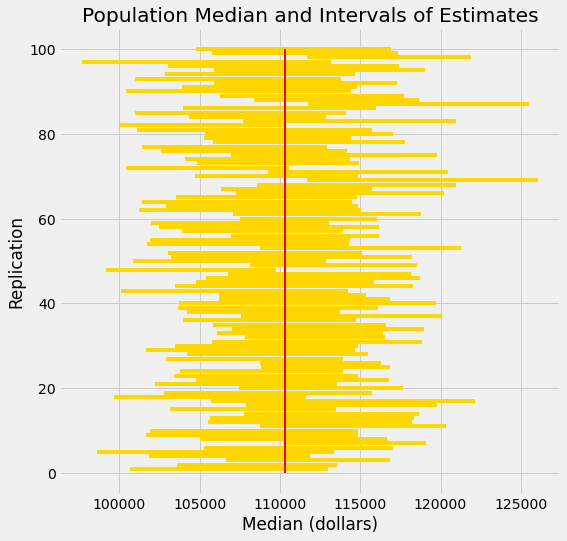

In [28]:
replication_number = np.arange(1, 101)

replication_number = replication_number.astype(str)

intervals2 = pd.DataFrame(np.array([left_ends, right_ends]), columns=[replication_number])

intervals2

plt.figure(figsize=(8,8))
for i in np.arange(100):
    ends = intervals2.iloc[:,i]
    plt.plot(ends, np.array([i+1, i+1]), color='gold')
plt.plot(np.array([pop_median, pop_median]), np.array([0, 100]), color='red', lw=2)
plt.xlabel('Median (dollars)')
plt.ylabel('Replication')
plt.title('Population Median and Intervals of Estimates');

To summarize what the simulation shows, suppose you are estimating the population median by the following process: 

- Draw a large random sample from the population.
- Bootstrap your random sample and get an estimate from the new random sample. 
- Repeat the above step thousands of times, and get thousands of estimates.
- Pick off the "middle 95%" interval of all the estimates.

That gives you one interval of estimates. Now if you repeat **the entire process** 100 times, ending up with 100 intervals, then about 95 of those 100 intervals will contain the population parameter.

In other words, this process of estimation captures the parameter about 95% of the time. 

You can replace 95% by a different value, as long as it's not 100. Suppose you replace 95% by 80% and keep the sample size fixed at 500. Then your intervals of estimates will be shorter than those we simulated here, because the "middle 80%" is a smaller range than the "middle 95%". Only about 80% of your intervals will contain the parameter.